In [1]:
import scipy as sp
import numpy as np
import BATT as b
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

%matplotlib inline

In [2]:
# initializing constants
K = 0.06    #liquid conductivity
s = 20.     #solid conductivity
a = 23300.  #area/volume
ac = 0.5    #alpha cathode
aa = 0.5    #alpha anode
io = 2e-7   #exchange current density
L = .5      #length
n = 1       #exchanged electrons
F = 96485   #Faraday's constant
R = 8.314   #gas constant
T = 298     #temperature
I = 0.1     #total current density
L_sep = 0.1 #length of separator
Resist_sep = 1 #resistance of separator per length


# graph analytically
# X = np.linspace(0., L, 200)
# Y=y = X/L
# v = L*np.sqrt(a*io*(n*F)/(R*T)*(K + s)/(K*s))
# i2 = I * K/(K + s)*(1 + (s*(K**-1)*np.sinh(v*(1-y)) - np.sinh(v*y))/np.sinh(v))

In [3]:
def Tafelfunc(IV, x):
    """
    uses Tafel kinetics
    """
    i1, i2, V1, V2 = IV
    
    di2 = -a*io*np.exp(-ac*n*F/(R*T)*(V1 - V2))
    di1 = -di2
    dV1 = -i1/s
    dV2 = -i2/K
    
    return di1, di2, dV1, dV2

def ObjectiveTafel(IVo):
    """
    Solves initial condition for tafel kinetic problem
    """
    i1o, V2o = IVo
    U = odeint(Tafelfunc, [i1o, I, 0, V2o], X)
    V = U[:,3]
    dV = np.diff(V)/np.diff(X)
    
    return U[0,0], dV[-1]

In [4]:
#analytically combined equation
def simplebattfunc(x, i):
    """
    Analytically solved current and voltage within electrode
    """
    i0, i1 = i
    di = i1
    d2i = a*io*(n*F)/(R*T)*(-I/s + i0*(1/s + 1/K))
    return di, d2i

#systems of differential equations with drop-in replacements possible
def linearbattfunc(x, IV):
    """
    Linear current and voltage within single electrode
    """
    i1, i2, V1, V2 = IV
    di2 = a*io*(n*F)/(R*T)*(V1 - V2)
    #Kinetics
    di1 = -di2
    #charge neutrality
    dV1 = -i1/s
    #solids ohms law
    dV2 = -i2/K
    #liquids ohms law
    return di1, di2, dV1, dV2

def BVbattfunc(x, IV):
    """
    Full Butler-Volmer kinetics
    """
    i1, i2, V1, V2 = IV
    di2 = a*io*(np.exp((n*F)/(R*T)*aa*(V1 - V2)) - np.exp((n*F)/(R*T)*-ac*(V1 - V2)))
    #Kinetics
    di1 = -di2
    #charge neutrality
    dV1 = -i1/s
    #solids ohms law
    dV2 = -i2/K
    #liquids ohms law
    return di1, di2, dV1, dV2

def Tafelfunc_a(x, IV):
    """
    uses Tafel kinetics
    """
    i1, i2, V1, V2 = IV

    taff = aa*n*F/(R*T)*(V1-V2)

    di2 = a*io*np.exp(taff)
    #Kinetics
    di1 = -di2
    #charge neutrality
    dV1 = -i1/s
    #solids ohms law
    dV2 = -i2/K
    #liquids ohms law

    return di1, di2, dV1, dV2

def Tafelfunc_c(x, IV):
    """
    uses Tafel kinetics
    """
    i1, i2, V1, V2 = IV

    taff = -ac*n*F/(R*T)*(V1-V2)

    di2 = -a*io*np.exp(taff)
    #Kinetics
    di1 = -di2
    #charge neutrality
    dV1 = -i1/s
    #solids ohms law
    dV2 = -i2/K
    #liquids ohms law

    return di1, di2, dV1, dV2


In [5]:

def BC_c(ya, yb):
    return (yb[0] - I), (ya[1] - I), ya[3], yb[1]

def BC_a(ya, yb):
    return (yb[1] - I), (ya[0] - I), ya[2], yb[0]

In [6]:
# x = np.linspace(0, L, 10)
# y = np.ones([4, 10])

# # y[:,0] = [0., I, .1, .1]
# # y[:,-1] = [I, 0., .1, .1]

# linear_IV = solve_bvp(linearbattfunc, BC_a, x, y)
# Ta_IV = solve_bvp(Tafelfunc_a, BC_a, x, y)
# Tc_IV = solve_bvp(Tafelfunc_c, BC_c, x, y)

# x_plot = np.linspace(0, L, 100)

# plt.figure(0)
# for i in range(2):
# #     plt.plot(x, y[i])
# #     plt.plot(x_plot, linear_IV.sol(x_plot)[i])
#     plt.plot(x_plot, Ta_IV.sol(x_plot)[i], color = 'r')
#     plt.plot(x_plot, Tc_IV.sol(x_plot)[i], color = 'b')
    
# plt.figure(1)
# for i in range(2, 4):
# #     plt.plot(x_plot, linear_IV.sol(x_plot)[i])
#     plt.plot(x_plot, Ta_IV.sol(x_plot)[i], color = 'r')
#     plt.plot(x_plot, Tc_IV.sol(x_plot)[i], color = 'b')

In [7]:
print(linear_IV.sol(x_plot)[3] - linear_IV.sol(x_plot)[2])

NameError: name 'linear_IV' is not defined

# Anode and cathode modeling

In [ ]:
#i1(0) = 0, i1(L) = I, i1(2L) = 0
#i2(0) = I, i2(L) = 0, i2(2L) = I
#v1(L) = 0

def BCOverall(ya, yb):
    return (yb[0] - I), (ya[1] - I), ya[3], yb[1], (yb[5] - I), (ya[4] - I), yb[7] - ya[3], yb[4]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])
    
def TafelOverall(x, IV):
    """
    uses Tafel kinetics
    """
#     i1, i2, V1, V2 = IV

#     taff = -ac*n*F/(R*T)*(V1-V2)

#     di2 = -a*io*np.exp(taff)
#     #Kinetics
#     di1 = -di2
#     #charge neutrality
#     dV1 = -i1/s
#     #solids ohms law
#     dV2 = -i2/K
#     #liquids ohms law

#     return di1, di2, dV1, dV2
    is_p, ie_p, Vs_p, Ve_p, is_n, ie_n, Vs_n, Ve_n = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_p = -ac*n*F/(R*T)*(Vs_p - Ve_p)
    taff_n = aa*n*F/(R*T)*(Vs_n - Ve_n)
    
    die_p = -a*io*np.exp(taff_p)
    die_n = a*io*np.exp(taff_n)
    #Kinetics
    dis_p = -die_p
    dis_n = -die_n
    #charge neutrality
    dVs_p = -is_p/s
    dVs_n = -is_n/s
    #solids ohms law
    dVe_p = -ie_p/K
    dVe_n = -ie_n/K
    #liquids ohms law

    return dis_p, die_p, dVs_p, dVe_p, dis_n, die_n, dVs_n, dVe_n



In [ ]:
N = 10
x = np.linspace(0, L, N)
# x2 = np.linspace(0,L, N)
y = np.zeros([8, N])

# y[:,0] = [0., I, .1, .1]
# y[:,-1] = [I, 0., .1, .1]

Mashed = solve_bvp(TafelOverall, BCOverall, x, y)
# Ta_IV = solve_bvp(Tafelfunc_a, BC_a, x, y)
# Tc_IV = solve_bvp(Tafelfunc_c, BC_c, x, y)

x_plot = np.linspace(0, L, 100)

plt.figure()
for i in range(2):
#     plt.plot(x, y[i])
#     plt.plot(x_plot, linear_IV.sol(x_plot)[i])
    plt.plot(x_plot, Mashed.sol(x_plot)[i], color = 'r', label = i)
    plt.legend(loc = 'best')

In [ ]:
a = np.append(Mashed.sol(x_plot)[4], Mashed.sol(x_plot)[0])
b = np.append(Mashed.sol(x_plot)[5], Mashed.sol(x_plot)[1])
c = np.append(Mashed.sol(x_plot)[6], Mashed.sol(x_plot)[2])
d = np.append(Mashed.sol(x_plot)[7], Mashed.sol(x_plot)[3])

In [ ]:
x_plot2 = np.linspace(0, 2*L, 200)
data = [a,b,c,d]
labels = ['solid current','electrolyte current','solid voltage','electrolyte voltage']
for i in range(4):
    plt.plot(x_plot2, data[i], label = labels[i], marker = '.', linestyle = 'none')
    plt.legend(loc = 'best')

In [8]:
Vwall1 = 1
Vwall2 = 1

def BCCath(ya, yb):
    return (yb[0] - I), (ya[1] - I), ya[3] - Vwall_2, yb[1]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])

def BCAn(ya, yb):
    return (yb[1] - I), (ya[0] - I), yb[3], yb[0]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])
      
def TafelCath(x, IV):
    """
    uses Tafel kinetics
    """
    is_p, ie_p, Vs_p, Ve_p = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_p = -ac*n*F/(R*T)*(Vs_p - Ve_p)
    die_p = -a*io*np.exp(taff_p)
    #Kinetics
    
    dis_p = -die_p
    #charge neutrality
    
    dVs_p = -is_p/s
    #solids ohms law
    
    dVe_p = -ie_p/K
    #liquids ohms law

    return dis_p, die_p, dVs_p, dVe_p

def TafelAn(x, IV):
    """
    uses Tafel kinetics
    """
    
    is_n, ie_n, Vs_n, Ve_n = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_n = aa*n*F/(R*T)*(Vs_n - Ve_n)
    die_n = a*io*np.exp(taff_n)
    #Kinetics
    
    dis_n = -die_n
    #charge neutrality
    
    dVs_n = -is_n/s
    #solids ohms law
    
    dVe_n = -ie_n/K
    #liquids ohms law

    return dis_n, die_n, dVs_n, dVe_n

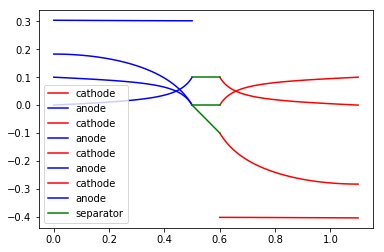

In [9]:
N = 10
N_sep = 20
x_cath = np.linspace(L + L_sep, 2*L + L_sep, N)
x_an = np.linspace(0, L, N)
y = np.zeros([4, N])

x_plot_cath = np.linspace(L + L_sep, L_sep + 2*L, 100)
x_plot_an = np.linspace(0, L, 100)

An = solve_bvp(TafelAn, BCAn, x_an, y)
Vwall_1 = An.sol(x_plot_an)[3][-1]

x_sep = np.linspace(L, L + L_sep, N_sep)
is_sep = np.ones(N_sep) * An.sol(x_plot_an)[0][-1]
ie_sep = np.ones(N_sep) * An.sol(x_plot_an)[1][-1]
Ve_sep = np.zeros(N_sep)
Ve_sep[0] = Vwall_1
for i in range(N_sep):
    Ve_sep[i] = Vwall_1 - (x_sep[i] - L) * Resist_sep

Vwall_2 = Ve_sep[-1]
Cath = solve_bvp(TafelCath, BCCath, x_cath, y)
# Ta_IV = solve_bvp(Tafelfunc_a, BC_a, x, y)
# Tc_IV = solve_bvp(Tafelfunc_c, BC_c, x, y)

for i in range(4):
    plt.plot(x_plot_cath, Cath.sol(x_plot_cath)[i], color = 'r', label = 'cathode')
    plt.plot(x_plot_an, An.sol(x_plot_an)[i], color = 'b', label = 'anode')

plt.plot(x_sep, Ve_sep, color = 'g')
plt.plot(x_sep, is_sep, color = 'g')
plt.plot(x_sep, ie_sep, color = 'g', label = 'separator')

plt.legend(loc = 'best')